## Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

---
## Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images 

In [202]:
#all defines
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
%matplotlib inline



In [203]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features
    
# Define a function to compute color histogram features  
def channel_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the one channels separately
    channel_hist = np.histogram(img, bins=nbins, range=bins_range)
    #print(channel_hist)
    # Return the individual histograms, bin_centers and feature vector
    return channel_hist[0]


# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
# KEEP IN MIND IF YOU DECIDE TO USE THIS FUNCTION LATER
# IN YOUR PROJECT THAT IF YOU READ THE IMAGE WITH 
# cv2.imread() INSTEAD YOU START WITH BGR COLOR!
# Convert image to new color space (if specified)
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(img)             
    features = cv2.resize(feature_image, size)
    # Return the feature vector
    return features

(64, 64, 3)
(3, 3, 2, 2, 9)
(324,)
(64,)
(388,)


Text(0.5,1,'HOG Visualization')

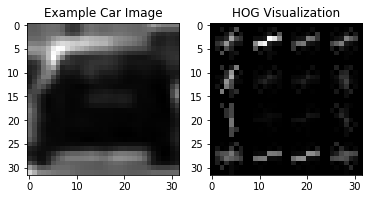

In [139]:

# Read in our vehicles and non-vehicles
images = glob.glob('dataset/*/*/*.png')
#print(images)
cars = []
notcars = []

for image in images:
    if 'non-vehicles' in image:
        notcars.append(image)
    else:
        cars.append(image)
        


# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
#apply appropriate scaling, as training samples are png so scale them up to 255
#image = np.uint8(image*255)
print(image.shape)
#print((np.min(image),np.max(image)))



# As discussed change this values from simple gray to HLS and take S here for HOG and L plane for binning
# Problem for S is there is lot of noise in that plane that why I took L plane for HOG and S plane to concatinate with 
# another option can be concatenate with histogram of S plane, this make sense
# Convert to HLS color space and separate the channels
hls_resize32 = bin_spatial(image, color_space='HLS', size=(32, 32))
#print(hls_resize32)
#print((np.min(hls_resize32),np.max(hls_resize32)))

#hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS).astype(np.float)
h_channel = hls_resize32[:,:,0]
l_channel = hls_resize32[:,:,1]
s_channel = hls_resize32[:,:,2]
#gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
hog_features, hog_image = get_hog_features(l_channel, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
print(hog_features.shape) # check the scikit-image HOG for dimention
# make it one dimention
hog_features = hog_features.ravel()
# With hog features the dimentions is 3 x 3 x 2 x 2 x 9 = 324 instead of 32 x 32
print(hog_features.shape)

# histogram of S plane
hist_features = channel_hist(s_channel, nbins=64, bins_range=(0, 256))
        # Append the new feature vector to the features list
print(hist_features.shape)

feature_vector = np.concatenate((hog_features, hist_features))
print(feature_vector.shape)


# first traing the classifier only on HOG for Saturation
#feature_vec = bin_spatial(l_channel, color_space='RGB', size=(32, 32))


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(l_channel, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

## Normalize your features and randomize a selection for training and testing


(8792, 1874)
(8968, 1874)


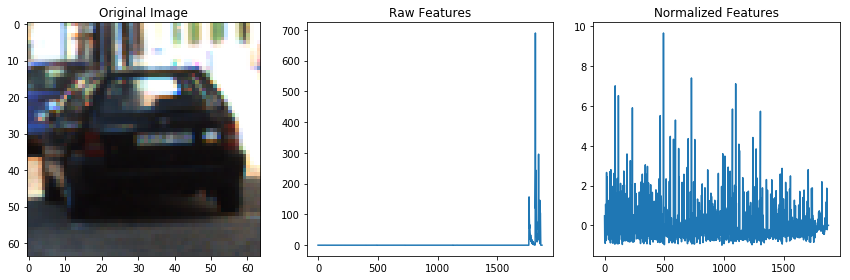

In [541]:
###### TODO ###########
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='HLS', spatial_size=(32, 32),
                     orient = 9, pix_per_cell = 8, cell_per_block = 2,
                     hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    count = 0
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        #print(count)
        count = count+1
        image = mpimg.imread(file)
        #apply appropriate scaling, as training samples are png so scale them up to 255
        image = np.uint8(image*255)
        # Convert to HLS color space, resize to 32x32 and separate the channels
        #yuv_resize32 = bin_spatial(image, color_space='YUV', size=spatial_size)
        #y_channel = yuv_resize32[:,:,0]
        
        
        
         # Convert to HLS color space, resize to 32x32 and separate the channels
        hls_resize32 = bin_spatial(image, color_space='HLS', size=spatial_size)
        #hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS).astype(np.float)
        h_channel = hls_resize32[:,:,0]
        l_channel = hls_resize32[:,:,1]
        s_channel = hls_resize32[:,:,2]
        
        # Call our function with vis=True to see an image output
        hog_features = get_hog_features(l_channel, orient, 
                                pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=False)
        hog_features = hog_features.ravel()
        
        # histogram of S plane
        hist_features_S = channel_hist(s_channel, nbins=hist_bins, bins_range=hist_range)
        hist_features_S = hist_features_S[10:]
        
        # histogram of H plane
        hist_features_H = channel_hist(h_channel, nbins=hist_bins, bins_range=hist_range)
        hist_features_H = hist_features_H[:-8]
        #print(hist_features_H)

        
        #concatenate the features to one feature vector
        feature_vector = np.concatenate((hog_features, hist_features_S, hist_features_H))
        #feature_vector = hog_features

        # Append the new feature vector to the features list
        features.append(feature_vector)
    # Return list of feature vectors
    return features


car_features = extract_features(cars, cspace='RGB', spatial_size=(64, 64),
                        orient = 9, pix_per_cell = 8, cell_per_block = 2,
                        hist_bins=64, hist_range=(0, 256))
print(np.shape(car_features))
notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(64, 64),
                        orient = 9, pix_per_cell = 8, cell_per_block = 2,
                        hist_bins=64, hist_range=(0, 256))
print(np.shape(notcar_features))


if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

## Prepare the Data for Classification

In [542]:
# NOTE: the next import is only valid 
# for scikit-learn version <= 0.17
# if you are using scikit-learn >= 0.18 then use this:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
#from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from sklearn import svm
from sklearn.model_selection import GridSearchCV



import time

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

## Train the SVM classifier 

In [543]:


GridSearch = False
# turn off the grid search if best parameters already identified on validation set

if GridSearch:

    #clf = SVC(kernel="linear")
    #parameters = {'kernel':('linear', 'rbf'), 'C':[0.1, 1, 10], 'gamma':[0.1, 1, 10]}
    #parameters = {'kernel':['rbf'], 'C':[3, 4, 5], 'gamma':[.002,.004, .006, .008]}
    parameters = {'kernel':['rbf'], 'C':[2, 4, 6, 8]}
    svc = svm.SVC()
    clf = GridSearchCV(svc, parameters)

    #### now your job is to fit the classifier
    #### using the training features/labels, and to
    #### make a set of predictions on the test data
    # Check the training time for the SVC
    t=time.time()
    clf.fit(X_train, y_train) 
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')


    #### store your predictions in a list named pred
    pred = clf.predict(X_test)
    acc = accuracy_score(pred, y_test)
    print('Test Accuracy of SVC = ', round(acc, 4))
    print('Best Results at following parameter set : ',clf.best_params_)
    

In [544]:
# just to confirm with the best parameters
#clf = svm.SVC(kernel='rbf',C=4,gamma= .004)
clf = svm.SVC(kernel='rbf',C=4)

# Check the training time for the SVC
t=time.time()
clf.fit(X_train, y_train) 
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')


#### store your predictions in a list named pred
pred = clf.predict(X_test)
acc = accuracy_score(pred, y_test)
print('Test Accuracy of SVC = ', round(acc, 4))

81.62 Seconds to train SVC...
Test Accuracy of SVC =  0.9952


## Apply a windowing on test image

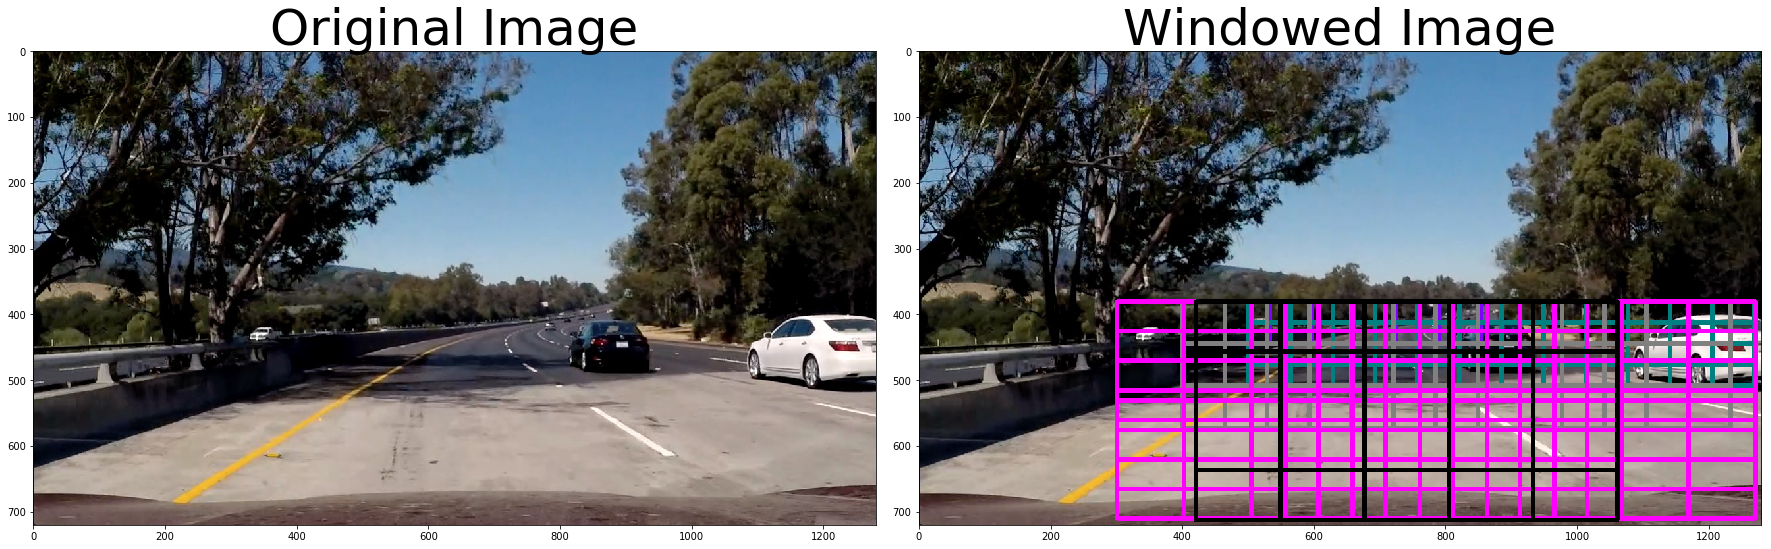

In [289]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Read one image to apply correction and check
img_test = mpimg.imread('./test_images/test5.jpg')
draw_image = np.copy(img_test)

windows = []
temp_windows = slide_window(img_test, x_start_stop=[500, 900], y_start_stop=[380,464], 
                    xy_window=(32, 32), xy_overlap=(0, 0))
windows = windows + temp_windows
draw_image = draw_boxes(draw_image, temp_windows, color=(128, 0, 255), thick=6)                    

temp_windows = slide_window(img_test, x_start_stop=[500, None], y_start_stop=[380,528], 
                    xy_window=(64, 64), xy_overlap=(0, 0))
windows = windows + temp_windows
draw_image = draw_boxes(draw_image, temp_windows, color=(0, 128, 255), thick=6)

temp_windows = slide_window(img_test, x_start_stop=[500, None], y_start_stop=[380,528], 
                    xy_window=(128, 64), xy_overlap=(0.5, 0.5))
windows = windows + temp_windows
draw_image = draw_boxes(draw_image, temp_windows, color=(0, 128, 128), thick=6)

temp_windows = slide_window(img_test, x_start_stop=[400, None], y_start_stop=[380,600], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
windows = windows + temp_windows
draw_image = draw_boxes(draw_image, temp_windows, color=(128, 128, 128), thick=6)

temp_windows = slide_window(img_test, x_start_stop=[300, None], y_start_stop=[380,None], 
                    xy_window=(256, 150), xy_overlap=(0.6, 0.7))
windows = windows + temp_windows
draw_image = draw_boxes(draw_image, temp_windows, color=(255, 0, 255), thick=6)

temp_windows = slide_window(img_test, x_start_stop=[420, 1100], y_start_stop=[380,None], 
                    xy_window=(256, 256), xy_overlap=(0.5, 0.7))
windows = windows + temp_windows
draw_image = draw_boxes(draw_image, temp_windows, color=(0, 0, 0), thick=6)


#draw_image = draw_boxes(img_test, windows, color=(0, 0, 0), thick=6)


# check the result on raw_image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_test)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(draw_image)
ax2.set_title('Windowed Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Windowing

Text(0.5,1,'Heat Map')

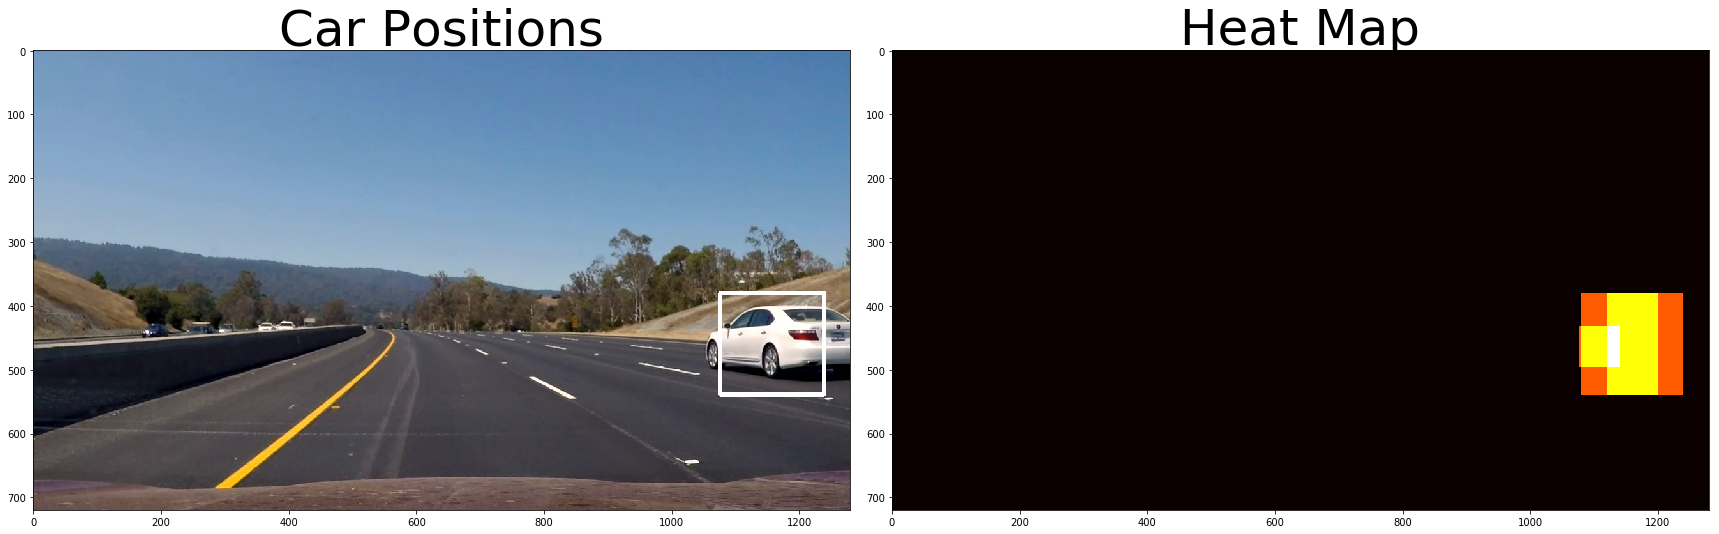

In [560]:
from scipy.ndimage.measurements import label


# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, crop_x, crop_w, crop_y, crop_h, scale_x, scale_y, X_scaler, clf, 
              orient, pix_per_cell, cell_per_block, hist_bins, hist_range,
              cells_per_step_x, cells_per_step_y):
    crop_img = img[crop_y:crop_y+crop_h,crop_x:crop_x+crop_w]


    #cells_per_step_x = 2  # Instead of overlap, define how many cells to step
    #cells_per_step_y = 2  # Instead of overlap, define how many cells to step

    #print(crop_img.shape)

    # step 1 : 
    crop_img_HLS = cv2.cvtColor(crop_img, cv2.COLOR_RGB2HLS)
    #crop_img_YUV = cv2.cvtColor(crop_img, cv2.COLOR_RGB2YUV)

    if scale_x != 1 or scale_y != 1:
        imshape = crop_img_HLS.shape
        crop_img_HLS_resize = cv2.resize(crop_img_HLS, (np.int(imshape[1]/scale_x), np.int(imshape[0]/scale_y)))
        #crop_img_YUV_resize = cv2.resize(crop_img_YUV, (np.int(imshape[1]/scale_x), np.int(imshape[0]/scale_y)))
    else:
        crop_img_HLS_resize = np.copy(crop_img_HLS)
        #crop_img_YUV_resize = np.copy(crop_img_YUV)

    #y_channel = crop_img_YUV_resize[:,:,0]
    
    h_channel = crop_img_HLS_resize[:,:,0]
    l_channel = crop_img_HLS_resize[:,:,1]
    s_channel = crop_img_HLS_resize[:,:,2]


    # Define blocks and steps as above
    nxblocks = (l_channel.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (l_channel.shape[0] // pix_per_cell) - cell_per_block + 1 

    # 32 was the orginal sampling rate, with 4 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1

    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step_x + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step_y + 1

    # Compute individual channel HOG features for the resized crop image
    hog_features_image = get_hog_features(l_channel, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    
    
    
    bbox_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step_y
            xpos = xb*cells_per_step_x
            # Extract HOG for this patch
            hog_features_window = hog_features_image[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            

            # histogram of S plane
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            hist_features_window_s = channel_hist(s_channel[ytop:ytop+window, xleft:xleft+window], nbins=hist_bins, bins_range=hist_range)
            hist_features_window_h = channel_hist(h_channel[ytop:ytop+window, xleft:xleft+window], nbins=hist_bins, bins_range=hist_range)

            hist_features_window_s = hist_features_window_s[10:]
            hist_features_window_h = hist_features_window_h[:-8]

            
            #concatenate the features to one feature vector
            feature_vector_window = np.hstack((hog_features_window ,hist_features_window_s,hist_features_window_h)).reshape(1, -1)
            #feature_vector_window = hog_features_window.reshape(1, -1)

            
            # Scale features and make a prediction
            test_features = X_scaler.transform(feature_vector_window)

            test_prediction = clf.predict(test_features)

            if test_prediction == 1:
                xleft = np.int(xleft*scale_x) + crop_x
                ytop = np.int(ytop*scale_y) + crop_y
                win_draw_x = np.int(window*scale_x)
                win_draw_y = np.int(window*scale_y)
                # ((x1, y1), (x2, y2))
                bbox_list.append(((xleft, ytop), (xleft+win_draw_x,ytop+win_draw_y)))
                
    return bbox_list
                #cv2.rectangle(draw_image,(xleft, ytop),(xleft+win_draw_x,ytop+win_draw_y),(0,0,255),6) 
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

img_test = mpimg.imread('./project_video/frame225.jpg')

heat = np.zeros_like(img_test[:,:,0]).astype(np.float)

orient = 9
pix_per_cell = 8
cell_per_block = 2
hist_bins=64
hist_range=(0, 256)

bbox_list = []

crop_x = 500;crop_w = 780
crop_y = 400;crop_h = 128
scale_x = 64/64;scale_y = 64/64
cells_per_step_x = 4; cells_per_step_y = 4
bbox_list = bbox_list + find_cars(img_test, crop_x, crop_w, crop_y, crop_h, scale_x, scale_y, X_scaler, clf,
                                  orient, pix_per_cell, cell_per_block, hist_bins, hist_range,
                                  cells_per_step_x, cells_per_step_y)


crop_x = 500;crop_w = 780
crop_y = 400;crop_h = 150
scale_x = 96/64;scale_y = 96/64
cells_per_step_x = 2; cells_per_step_y = 4
bbox_list = bbox_list + find_cars(img_test, crop_x, crop_w, crop_y, crop_h, scale_x, scale_y, X_scaler, clf,
                                  orient, pix_per_cell, cell_per_block, hist_bins, hist_range,
                                  cells_per_step_x, cells_per_step_y)


crop_x = 500;crop_w = 780
crop_y = 400;crop_h = 128
scale_x = 96/64;scale_y = 64/64
cells_per_step_x = 2; cells_per_step_y = 2
bbox_list = bbox_list + find_cars(img_test, crop_x, crop_w, crop_y, crop_h, scale_x, scale_y, X_scaler, clf,
                                  orient, pix_per_cell, cell_per_block, hist_bins, hist_range,
                                  cells_per_step_x, cells_per_step_y)

#for right portion
crop_x = 1000;crop_w = 280
crop_y = 380;crop_h = 150 #might be go back to same y as 96 x 96 
scale_x = 128/64;scale_y = 64/64
cells_per_step_x = 2; cells_per_step_y = 2
bbox_list = bbox_list + find_cars(img_test, crop_x, crop_w, crop_y, crop_h, scale_x, scale_y, X_scaler, clf,
                                  orient, pix_per_cell, cell_per_block, hist_bins, hist_range,
                                  cells_per_step_x, cells_per_step_y)

crop_x = 1000;crop_w = 280
crop_y = 380;crop_h = 250 #might be go back to same y as 96 x 96 
scale_x = 128/64;scale_y = 128/64
cells_per_step_x = 2; cells_per_step_y = 4
bbox_list = bbox_list + find_cars(img_test, crop_x, crop_w, crop_y, crop_h, scale_x, scale_y, X_scaler, clf,
                                  orient, pix_per_cell, cell_per_block, hist_bins, hist_range,
                                  cells_per_step_x, cells_per_step_y)

crop_x = 1000;crop_w = 280
crop_y = 380;crop_h = 250 #might be go back to same y as 96 x 96 
scale_x = 160/64;scale_y = 160/64
cells_per_step_x = 2; cells_per_step_y = 4
bbox_list = bbox_list + find_cars(img_test, crop_x, crop_w, crop_y, crop_h, scale_x, scale_y, X_scaler, clf,
                                  orient, pix_per_cell, cell_per_block, hist_bins, hist_range,
                                  cells_per_step_x, cells_per_step_y)

crop_x = 1000;crop_w = 280
crop_y = 380;crop_h = 250 #might be go back to same y as 96 x 96 
scale_x = 192/64;scale_y = 128/64
cells_per_step_x = 2; cells_per_step_y = 4
bbox_list = bbox_list + find_cars(img_test, crop_x, crop_w, crop_y, crop_h, scale_x, scale_y, X_scaler, clf,
                                  orient, pix_per_cell, cell_per_block, hist_bins, hist_range,
                                  cells_per_step_x, cells_per_step_y)

# for lower portion
crop_x = 500;crop_w = 550
crop_y = 500;crop_h = 150 #might be go back to same y as 96 x 96 
scale_x = 128/64;scale_y = 64/64
cells_per_step_x = 2; cells_per_step_y = 4
bbox_list = bbox_list + find_cars(img_test, crop_x, crop_w, crop_y, crop_h, scale_x, scale_y, X_scaler, clf,
                                  orient, pix_per_cell, cell_per_block, hist_bins, hist_range,
                                  cells_per_step_x, cells_per_step_y)
crop_x = 500;crop_w = 550
crop_y = 500;crop_h = 150 #might be go back to same y as 96 x 96 
scale_x = 128/64;scale_y = 128/64
cells_per_step_x = 2; cells_per_step_y = 4
bbox_list = bbox_list + find_cars(img_test, crop_x, crop_w, crop_y, crop_h, scale_x, scale_y, X_scaler, clf,
                                  orient, pix_per_cell, cell_per_block, hist_bins, hist_range,
                                  cells_per_step_x, cells_per_step_y)

crop_x = 500;crop_w = 550
crop_y = 500;crop_h = 150 #might be go back to same y as 96 x 96 
scale_x = 160/64;scale_y = 160/64
cells_per_step_x = 2; cells_per_step_y = 4
bbox_list = bbox_list + find_cars(img_test, crop_x, crop_w, crop_y, crop_h, scale_x, scale_y, X_scaler, clf,
                                  orient, pix_per_cell, cell_per_block, hist_bins, hist_range,
                                  cells_per_step_x, cells_per_step_y)

# Add heat to each box in box list
heat = add_heat(heat,bbox_list)


# Apply threshold to help remove false positives
heat = apply_threshold(heat,2)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img_test), labels)
#draw_img = draw_boxes(np.copy(img_test), rect_list_temp, color=(0, 0, 255), thick=6)   

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(draw_img)
ax1.set_title('Car Positions', fontsize=50)
ax2.imshow(heatmap, cmap='hot')
ax2.set_title('Heat Map', fontsize=50)


## Video Pipeline

In [606]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Define a class to receive the characteristics of each line detection
class Vehicle():
    def __init__(self):
        # was the vehicle detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_bbox_list = [] 
        
        #current index in the arrays
        self.idx = 0
        
        #reset_counter
        self.rst_cnt = 0
        
        #decision whether to append or use idx to put the new value
        self.append = True

In [607]:
# Define objects of class Vehicle for taking records for last frames
Prev_V = Vehicle()
# no of iteration to consider for the final result calculation
N = 15 

# some global parameters
frame = 0

# reset to take fresh measurements after 5 successive sanity check failed frames
reset = False
rst_bound = 5


# main code to process each frame
def process_frame(img_c):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    global frame, reset, sanity_check_en

    img_test = img_c
    heat = np.zeros_like(img_test[:,:,0]).astype(np.float)
    final_heat = np.zeros_like(img_test[:,:,0]).astype(np.float)

    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    hist_bins=64
    hist_range=(0, 256)

    bbox_list = []

    '''crop_x = 500;crop_w = 780
    crop_y = 400;crop_h = 128
    scale_x = 64/32;scale_y = 64/32
    cells_per_step_x = 2; cells_per_step_y = 2
    bbox_list = bbox_list + find_cars(img_test, crop_x, crop_w, crop_y, crop_h, scale_x, scale_y, X_scaler, clf,
                                      orient, pix_per_cell, cell_per_block, hist_bins, hist_range,
                                      cells_per_step_x, cells_per_step_y)


    crop_x = 500;crop_w = 780
    crop_y = 420;crop_h = 150
    scale_x = 96/32;scale_y = 96/32
    cells_per_step_x = 2; cells_per_step_y = 2
    bbox_list = bbox_list + find_cars(img_test, crop_x, crop_w, crop_y, crop_h, scale_x, scale_y, X_scaler, clf,
                                      orient, pix_per_cell, cell_per_block, hist_bins, hist_range,
                                      cells_per_step_x, cells_per_step_y)


    crop_x = 500;crop_w = 780
    crop_y = 400;crop_h = 128
    scale_x = 96/32;scale_y = 64/32
    cells_per_step_x = 2; cells_per_step_y = 2
    bbox_list = bbox_list + find_cars(img_test, crop_x, crop_w, crop_y, crop_h, scale_x, scale_y, X_scaler, clf,
                                      orient, pix_per_cell, cell_per_block, hist_bins, hist_range,
                                      cells_per_step_x, cells_per_step_y)

    #for right portion
    crop_x = 1000;crop_w = 280
    crop_y = 380;crop_h = 150 #might be go back to same y as 96 x 96 
    scale_x = 128/32;scale_y = 64/32
    cells_per_step_x = 1; cells_per_step_y = 2
    bbox_list = bbox_list + find_cars(img_test, crop_x, crop_w, crop_y, crop_h, scale_x, scale_y, X_scaler, clf,
                                      orient, pix_per_cell, cell_per_block, hist_bins, hist_range,
                                      cells_per_step_x, cells_per_step_y)

    crop_x = 1000;crop_w = 280
    crop_y = 380;crop_h = 250 #might be go back to same y as 96 x 96 
    scale_x = 128/32;scale_y = 128/32
    cells_per_step_x = 1; cells_per_step_y = 2
    bbox_list = bbox_list + find_cars(img_test, crop_x, crop_w, crop_y, crop_h, scale_x, scale_y, X_scaler, clf,
                                      orient, pix_per_cell, cell_per_block, hist_bins, hist_range,
                                      cells_per_step_x, cells_per_step_y)

    crop_x = 1000;crop_w = 280
    crop_y = 380;crop_h = 250 #might be go back to same y as 96 x 96 
    scale_x = 192/32;scale_y = 128/32
    cells_per_step_x = 1; cells_per_step_y = 2
    bbox_list = bbox_list + find_cars(img_test, crop_x, crop_w, crop_y, crop_h, scale_x, scale_y, X_scaler, clf,
                                      orient, pix_per_cell, cell_per_block, hist_bins, hist_range,
                                      cells_per_step_x, cells_per_step_y)

    # for lower portion
    crop_x = 500;crop_w = 550
    crop_y = 500;crop_h = 150 #might be go back to same y as 96 x 96 
    scale_x = 128/32;scale_y = 64/32
    cells_per_step_x = 1; cells_per_step_y = 2
    bbox_list = bbox_list + find_cars(img_test, crop_x, crop_w, crop_y, crop_h, scale_x, scale_y, X_scaler, clf,
                                      orient, pix_per_cell, cell_per_block, hist_bins, hist_range,
                                      cells_per_step_x, cells_per_step_y)
    crop_x = 500;crop_w = 550
    crop_y = 500;crop_h = 150 #might be go back to same y as 96 x 96 
    scale_x = 128/32;scale_y = 128/32
    cells_per_step_x = 1; cells_per_step_y = 2
    bbox_list = bbox_list + find_cars(img_test, crop_x, crop_w, crop_y, crop_h, scale_x, scale_y, X_scaler, clf,
                                      orient, pix_per_cell, cell_per_block, hist_bins, hist_range,
                                      cells_per_step_x, cells_per_step_y)'''

    crop_x = 500;crop_w = 780
    crop_y = 400;crop_h = 128
    scale_x = 64/64;scale_y = 64/64
    cells_per_step_x = 4; cells_per_step_y = 4
    bbox_list = bbox_list + find_cars(img_test, crop_x, crop_w, crop_y, crop_h, scale_x, scale_y, X_scaler, clf,
                                      orient, pix_per_cell, cell_per_block, hist_bins, hist_range,
                                      cells_per_step_x, cells_per_step_y)


    crop_x = 500;crop_w = 780
    crop_y = 400;crop_h = 150
    scale_x = 96/64;scale_y = 96/64
    cells_per_step_x = 2; cells_per_step_y = 4
    bbox_list = bbox_list + find_cars(img_test, crop_x, crop_w, crop_y, crop_h, scale_x, scale_y, X_scaler, clf,
                                      orient, pix_per_cell, cell_per_block, hist_bins, hist_range,
                                      cells_per_step_x, cells_per_step_y)


    crop_x = 500;crop_w = 780
    crop_y = 400;crop_h = 128
    scale_x = 96/64;scale_y = 64/64
    cells_per_step_x = 2; cells_per_step_y = 2
    bbox_list = bbox_list + find_cars(img_test, crop_x, crop_w, crop_y, crop_h, scale_x, scale_y, X_scaler, clf,
                                      orient, pix_per_cell, cell_per_block, hist_bins, hist_range,
                                      cells_per_step_x, cells_per_step_y)

    #for right portion
    crop_x = 1000;crop_w = 280
    crop_y = 380;crop_h = 150 #might be go back to same y as 96 x 96 
    scale_x = 128/64;scale_y = 64/64
    cells_per_step_x = 2; cells_per_step_y = 2
    bbox_list = bbox_list + find_cars(img_test, crop_x, crop_w, crop_y, crop_h, scale_x, scale_y, X_scaler, clf,
                                      orient, pix_per_cell, cell_per_block, hist_bins, hist_range,
                                      cells_per_step_x, cells_per_step_y)

    crop_x = 1000;crop_w = 280
    crop_y = 380;crop_h = 250 #might be go back to same y as 96 x 96 
    scale_x = 128/64;scale_y = 128/64
    cells_per_step_x = 2; cells_per_step_y = 4
    bbox_list = bbox_list + find_cars(img_test, crop_x, crop_w, crop_y, crop_h, scale_x, scale_y, X_scaler, clf,
                                      orient, pix_per_cell, cell_per_block, hist_bins, hist_range,
                                      cells_per_step_x, cells_per_step_y)

    crop_x = 1000;crop_w = 280
    crop_y = 380;crop_h = 250 #might be go back to same y as 96 x 96 
    scale_x = 160/64;scale_y = 160/64
    cells_per_step_x = 2; cells_per_step_y = 4
    bbox_list = bbox_list + find_cars(img_test, crop_x, crop_w, crop_y, crop_h, scale_x, scale_y, X_scaler, clf,
                                      orient, pix_per_cell, cell_per_block, hist_bins, hist_range,
                                      cells_per_step_x, cells_per_step_y)

    crop_x = 1000;crop_w = 280
    crop_y = 380;crop_h = 250 #might be go back to same y as 96 x 96 
    scale_x = 192/64;scale_y = 128/64
    cells_per_step_x = 2; cells_per_step_y = 4
    bbox_list = bbox_list + find_cars(img_test, crop_x, crop_w, crop_y, crop_h, scale_x, scale_y, X_scaler, clf,
                                      orient, pix_per_cell, cell_per_block, hist_bins, hist_range,
                                      cells_per_step_x, cells_per_step_y)

    # for lower portion
    crop_x = 500;crop_w = 550
    crop_y = 500;crop_h = 150 #might be go back to same y as 96 x 96 
    scale_x = 128/64;scale_y = 64/64
    cells_per_step_x = 2; cells_per_step_y = 4
    bbox_list = bbox_list + find_cars(img_test, crop_x, crop_w, crop_y, crop_h, scale_x, scale_y, X_scaler, clf,
                                      orient, pix_per_cell, cell_per_block, hist_bins, hist_range,
                                      cells_per_step_x, cells_per_step_y)
    crop_x = 500;crop_w = 550
    crop_y = 500;crop_h = 150 #might be go back to same y as 96 x 96 
    scale_x = 128/64;scale_y = 128/64
    cells_per_step_x = 2; cells_per_step_y = 4
    bbox_list = bbox_list + find_cars(img_test, crop_x, crop_w, crop_y, crop_h, scale_x, scale_y, X_scaler, clf,
                                      orient, pix_per_cell, cell_per_block, hist_bins, hist_range,
                                      cells_per_step_x, cells_per_step_y)

    crop_x = 500;crop_w = 550
    crop_y = 500;crop_h = 150 #might be go back to same y as 96 x 96 
    scale_x = 160/64;scale_y = 160/64
    cells_per_step_x = 2; cells_per_step_y = 4
    bbox_list = bbox_list + find_cars(img_test, crop_x, crop_w, crop_y, crop_h, scale_x, scale_y, X_scaler, clf,
                                      orient, pix_per_cell, cell_per_block, hist_bins, hist_range,
                                      cells_per_step_x, cells_per_step_y)
    
    if bbox_list:
        heat = add_heat(heat,bbox_list)
        # Apply threshold to help remove false positives
        heat = apply_threshold(heat,1) # change to 0 for 32 or use the code below
        if Prev_V.append:
            Prev_V.recent_bbox_list.append(heat)
        else:
            Prev_V.recent_bbox_list[Prev_V.idx] = heat
        Prev_V.idx = Prev_V.idx + 1
        if Prev_V.idx == N:
            Prev_V.idx = 0
            Prev_V.append = False
    
    if len(Prev_V.recent_bbox_list) > N/2:
        for heat in Prev_V.recent_bbox_list:
            # Add heat to each box in box list
            final_heat = final_heat + heat
        if len(Prev_V.recent_bbox_list) < N:
            # Apply threshold to help remove false positives
            final_heat = apply_threshold(final_heat,5)
        else:
            # Apply threshold to help remove false positives
            final_heat = apply_threshold(final_heat,10)    
    
    #for 32 window size use the code below
    '''if bbox_list:
        if Prev_V.append:
            Prev_V.recent_bbox_list.append(bbox_list)
        else:
            Prev_V.recent_bbox_list[Prev_V.idx] = bbox_list
        Prev_V.idx = Prev_V.idx + 1
        if Prev_V.idx == N:
            Prev_V.idx = 0
            Prev_V.append = False

        
    if len(Prev_V.recent_bbox_list) > N/2:
        for bbox_list in Prev_V.recent_bbox_list:
            # Add heat to each box in box list
            heat = add_heat(heat,bbox_list)
        if len(Prev_V.recent_bbox_list) < N:
            # Apply threshold to help remove false positives
            heat = apply_threshold(heat,2)
        else:
            # Apply threshold to help remove false positives
            heat = apply_threshold(heat,3)'''
    

    

    # Visualize the heatmap when displaying    
    heatmap = np.clip(final_heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img_test), labels)
    #mpimg.imsave('project_video_output/frame'+str(frame)+'.jpg',result_c)
        
        
    frame = frame + 1
    return draw_img

In [608]:
# main code to process each frame
frame = 0
def extract_frame(img_c):
    global frame
    frame = frame + 1
    mpimg.imsave('project_video/frame'+str(frame)+'.jpg',img_c) 
    return img_c

In [609]:
white_output = './project_video_out2.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("./project_video.mp4")#.subclip(16,21)

white_clip = clip1.fl_image(process_frame) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


[MoviePy] >>>> Building video ./project_video_out2.mp4
[MoviePy] Writing video ./project_video_out2.mp4



 12%|█▏        | 152/1261 [05:53<42:48,  2.32s/it]


 24%|██▍       | 303/1261 [11:50<37:52,  2.37s/it]


 36%|███▌      | 454/1261 [17:48<32:06,  2.39s/it]


 48%|████▊     | 601/1261 [1:05:19<25:29,  2.32s/it]


 59%|█████▉    | 747/1261 [1:11:28<21:59,  2.57s/it]


 71%|███████   | 893/1261 [1:17:45<15:55,  2.60s/it]


 82%|████████▏ | 1038/1261 [1:24:04<09:41,  2.61s/it]


 94%|█████████▎| 1181/1261 [1:30:19<03:33,  2.66s/it]


100%|█████████▉| 1260/1261 [1:57:17<00:02,  2.30s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_out2.mp4 

CPU times: user 51min 8s, sys: 40 s, total: 51min 48s
Wall time: 1h 57min 18s


In [415]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))